# Descriptores de textura

## Scale-Invariant Feature Transform (SIFT)

El algoritmo `SIFT` se utiliza en aplicaciones que involucran un escalado de la imagen. Sirve para la detección de esquinas, bordes o texturas, siendo estable frente a perturbaciones y transformaciones que pueda sufrir la imagen. Es invariante a posición, escala, rotación, iluminación y contraste. El algoritmo consta de las siguientes fases:

1. Detección de extremos en la escala-espacio. La escala-espacio se crea aplicando convoluciones entre la imagen original (I) y un kernel gaussiano (G) con diferentes escalas (𝜎).

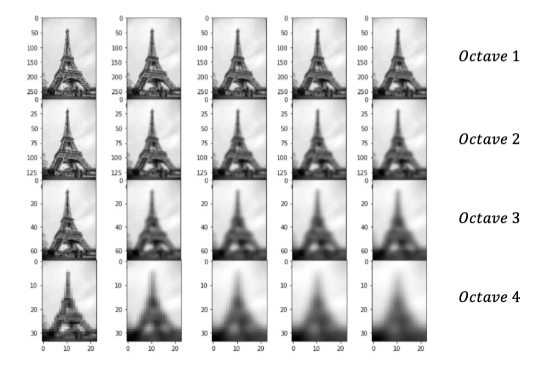

Todas las imágenes ( 𝐿 ) generadas forman una “octave”. Este proceso se repite para obtener varias “octaves”, donde el tamaño de cada una de ellas es la mitad de la anterior.


2. Diferencia de Gausianas (DOG). Se genera un set de imágenes basado en la diferencia de las imágenes tras ser convolucionadas con el kernel gausiano. Estas diferencias de gausianas son muy buenas para encontrar puntos de interés en las imágenes. El procedimiento se aplica para todas las octaves como la diferencia entre una imagen con dos escalas diferentes, por ejemplo, 𝜎 y k𝜎.

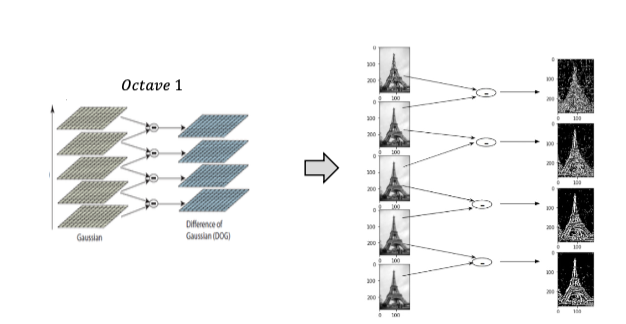


3. Detección de posibles puntos de interés. Cada píxel de una imagen es comparada con los 8 píxeles vecinos de esa misma imagen, y con los 9 píxeles (en esa misma posición) en las escalas directamente posterior y anterior. Si el valor del píxel es un extremo local (mayor o menor intensidad), ese píxel se convierte en un posible punto de interés.


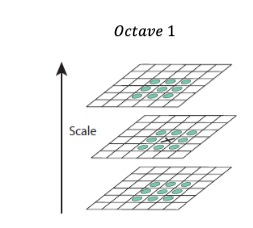


4. Localización de puntos de interés. El punto anterior genera muchos posibles puntos de interés, por lo que en este paso hay que quedarse únicamente con los que son útiles. Se aplican series de Tylor (segundo orden) sobre cada posible punto de interés para lidiar con los keypoints de bajo contraste. Si la intensidad es menor que un determinado umbral (0.03), se rechaza. Además, la Diferencia de Gausianas (DoG) presenta una alta respuesta para bordes, por lo que muchos keypoints se detectan cerca de los borde. No obstante, tenemos que eliminar aquellos que no sean robustos al ruido. Para ello, se utiliza la “Hessian matrix (H)” de 2x2 que permite obtener la curvatura principal.


5. Asignación de la orientación. Una vez ya tenemos localizados los keypoints estables frente a cambios de escala, bajo contraste y ruido, asignamos una orientación a cada punto de interés para hacerlo invariante a las rotaciones. Se selecciona un vecindario alrededor de un punto de interés y se calcula la magnitud y la dirección del gradiente.

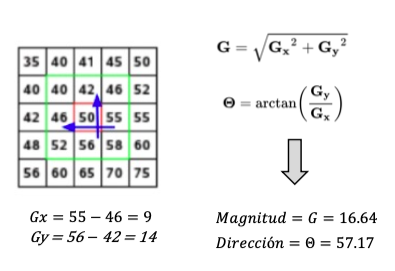


6. La orientación se calcula mediante un histograma de 36 bins que cubre los 360 grados. Si por ejemplo la dirección del gradiente en un punto es 57.17 grados, esto corresponde al bin 50-59 del histograma. La cantidad que se añade a dicho bin es la magnitud del gradiente, por ejemplo, 16.64. Tras hacer esto con todos los píxeles del vecindario del punto de interés, el histograma tendrá un pico en cada punto. El valor más alto del histograma y aquellos picos mayores del 80% se tienen en cuenta para calcular la orientación. Esto crea puntos de interés con la misma localización y escala, pero diferentes direcciones.

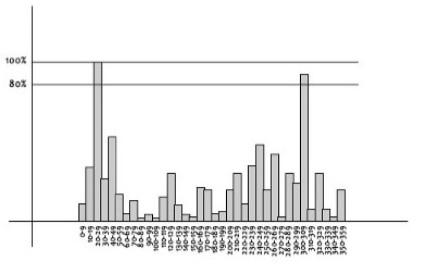


7. Descriptor del punto de interés. Una vez cada punto de interés tiene su localización, escala y orientación, es momento de calcular el descriptor que permite identificar un mismo punto en una imagen transformada a partir de la original. Para ello, se toma una ventana de 16x16 alrededor del punto de interés. Dicha ventana se divide en bloques de 4x4 y para cada bloque, se calculan la magnitud y las orientaciones de los píxeles obteniendo un histograma de orientación de 8 bins. De esta manera, se obtienen 16 histogramas de 8 bins, dando lugar a un figerprint de 128 características.

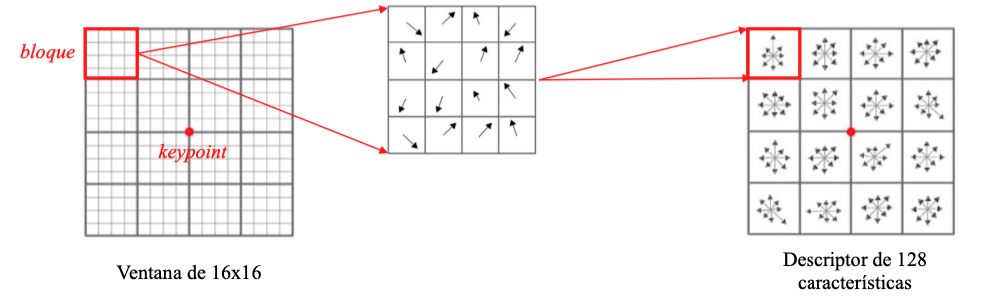



In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('images/photographer.png')

window = cv2.rectangle(img.copy(), (400,80), (420,100), (0, 0, 255), 5)
window = cv2.rectangle(window, (490,490), (510,510), (0, 255, 0), 5)
plt.imshow(window, cmap='gray')
plt.show()

In [ ]:
# Seleccionamos una región del cielo y una de la hierba
cielo = img[80:100, 400:420]
hierba = img[490:510, 490:510]

fig, ax = plt.subplots(1,2)
ax[0].imshow(cielo, cmap='gray')
ax[0].set_title('cielo')
ax[1].imshow(hierba, cmap='gray')
ax[1].set_title('hierba')
plt.show()

### MATRIZ DE COOCURRENCIA

In [ ]:
#!pip install tabulate

In [ ]:
# MATRIZ DE COOCURRENCIA (Gray-Level Cooccurence Matrix - GLCM)
from tabulate import tabulate
from skimage.feature import graycomatrix, graycoprops
headers = ['','cielo', 'hierba']
CN, DIS, H, ASM, E, COR = ['contraste'], ['disimilitud'], ['homogeneidad'], ['ASM'], ['Energía'], ['Correlación']

patches = []
patches.append(cielo)
patches.append(hierba)

for i in range(len(patches)):
    image = cv2.cvtColor(patches[i], cv2.COLOR_BGR2GRAY)
    GLCM = graycomatrix(image, distances=[5], angles=[0], levels=np.max(image)+1, symmetric=True, normed=True) #la distance es la cantidad de pixeles adyacentes que quiero analizar
    plt.imshow(GLCM[:,:,0,0], cmap='gray')
    plt.show()
    CN.append(graycoprops(GLCM, 'contrast')[0,0])
    DIS.append(graycoprops(GLCM, 'dissimilarity')[0,0])
    H.append(graycoprops(GLCM, 'homogeneity')[0,0])
    ASM.append(graycoprops(GLCM, 'ASM')[0,0])
    E.append(graycoprops(GLCM, 'energy')[0,0])
    COR.append(graycoprops(GLCM, 'correlation')[0,0])

my_data = [tuple(CN), tuple(DIS), tuple(H), tuple(ASM), tuple(E), tuple(COR)]

print(tabulate(my_data, headers=headers))

### Scale-Invariant Feature Transform

In [ ]:
# SIFT algorithm
img = cv2.imread('images/photographer.png')

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp = sift.detect(img, None)

# Extraemos el descriptor para obtener el fingreprint
kp, des = sift.compute(img, kp)
print(np.shape(des)) # Me imprime la cantidad de puntos de interes por la cantidad de histogramas por los bins (en este caso 128)
#print(des) 
# Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
img=cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

#Cada uno de esas 1672 instancias tienen 128 características (1672,128)

In [ ]:
# Puntos de interes para la imagen rotada
new_img = cv2.imread('images/photographer.png')
rows, cols, ch = img.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),angle=45,scale=1) # Defino la matriz de transformación
new_img = cv2.warpAffine(new_img,M,(cols,rows)) # Aplico la transformación

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp_rot = sift.detect(new_img, None)

# Extraemos el descriptor para obtener el fingreprint
kp_rot, des_rot = sift.compute(new_img, kp_rot)
print(np.shape(des_rot)) # Me imprime la cantidad de puntos de interes por la cantidad de histogramas por los bins (en este caso 128)
# print(des) # Matriz donde las filas son los keypoints y las columnas las características de dichos puntos clave

# Visualizamos los puntos de interés
new_img=cv2.drawKeypoints(new_img, kp_rot, new_img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(new_img)
plt.show()

In [ ]:
# feature matching
from skimage import io
bf = cv2.BFMatcher.create ( cv2.NORM_L1 ,crossCheck = True )
matches = bf.match (des , des_rot )
matches = sorted ( matches , key = lambda x : x.distance )
print ( np.shape ( matches ) )
img_match = cv2.drawMatches ( img , kp , new_img , kp_rot , matches [ : 10 ] , new_img , flags = 10 )
plt.imshow ( img_match )
plt.show ( )

"""
Podemos observar como se han encontrado 968 punto de interés comunes entre ambas imágenes
"""

### Histogram of Oriented Gradients 

El histograma de gradientes utiliza la distribución de la dirección de los gradientes como características, ya que la magnitud del gradiente presenta una alta respuesta a los cambios de intensidad elevados. Esto permite obtener información sobre la forma de los objetos.
El algoritmo consta de los siguientes pasos:

1. Cálculo de los gradientes de la imagen. Se calculan los gradientes horizontales y verticales mediante el filtrado de la imagen con un kernel de tamaño 1. Se puede aplicar el algoritmo de Sobel visto anteriormente. Una vez se han obtenido las matrices 𝐺3 y 𝐺5 que representan las aproximaciones de las derivadas de intensidades, se calcula la magnitud y la dirección del gradiente.


2. Cálculo de gradientes en celdas de 8x8. El hecho de escoger celdas de 8x8 píxeles es porque cada píxel tendrá 2 valores (magnitud y dirección), lo que da lugar a un total de 128 números. Estos 128 valores se pueden representar en un histograma de 9 bins correspondiente a los ángulos 0, 20, 40, 60, 80, 100, 120, 140 y 160. Estas 9 características dan lugar a una representación óptima que no solo es la más compacta, sino que también es robusta frente al ruido. Como se puede observar, la dirección del gradiente se evalúa entre 0 y 180 grados, en lugar de 0 y 360. Esto se denomina “unsigned” gradients porque la dirección del gradiente se representa en valor absoluto.

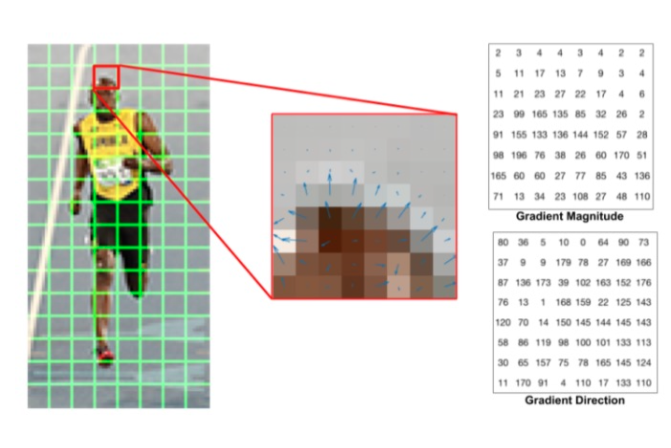

3. Cálculo del histograma de gradientes de 9-bins. Una vez calculadas la magnitud y la dirección de los gradientes de cada píxel en la celda de 8x8, se construye un histograma de 9-bins donde cada bin representa una dirección y el valor de dicho bin viene determinado por la magnitud.

    - Si la dirección coincide con la etiqueta de un bin específico, entonces se añade íntegramente el valor de su magnitud a dicho bin (azul).
    - Si la dirección toma valores entre dos bins, la magnitud correspondiente se añadirá a los dos bins de manera proporcional (rojo).
    
    
> Nota: En el caso de que la dirección sea mayor de 180o, la magnitud se añadirá de manera proporcional entre los bins de 160 y 0, ya que 0 equivale a 180. Finalmente, se crea el histograma de gradientes con las contribuciones de todos los píxeles de la celda 8x8.

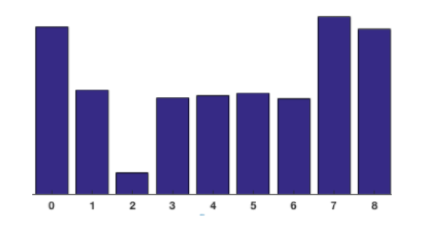

4. Normalización del histograma de gradientes. El objetivo es que el descriptor sea invariante frente a variaciones en la intensidad de los píxeles, es decir, invariante a los cambios de contraste y/o luminosidad. Para ello, se recorre la imagen en tamaños de ventana de 16x16, es decir, en cada paso se cogerán 4 celdas de 8x8. De esta manera, se obtendrán 4 histogramas de 9 bins que dan lugar a un vector de características de 36 elementos. Estos elementos se normalizan de acuerdo a una regla (L1 o L2, por ejemplo). Después, la ventana se desplaza una celda (8 píxeles) y se vuelven a calcular y normalizar los 36 elementos.


5. Cálculo del histogram of oriented gradients (HOG). En nuestro caso particular, el tamaño de la imagen era de 128x64 píxeles. Por tanto, en el eje horizontal hay 7 celdas de 16x16 píxeles (con solapamiento de celdas como se muestra en la animación) y en el eje vertical, 15 celdas.
Puesto que en cada celda de 16x16 píxeles obteníamos un vector de características con 36 elementos, el descriptor final tendrá un total de 7*15*36=3780 características que son representativas de la imagen bajo estudio.

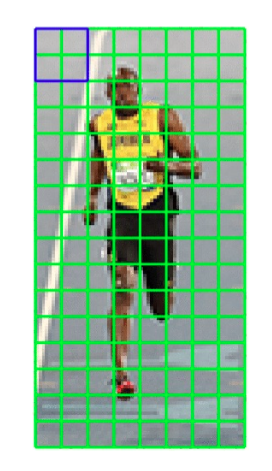


In [ ]:
# HISTOGRAM OF ORIENTED GRADIENTS

from skimage import io
img = io.imread('images/pedestrian.jpg')
img = np.float32(img/255)
crop = img[75:550,475:700]
crop = cv2.resize(crop, (64, 128))

plt.imshow(crop, cmap='gray')
plt.show()

In [ ]:
# Calculamos el gradiente con el kernel de Sobel
crop = np.float32(crop)
gx = cv2.Sobel(crop, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(crop, cv2.CV_32F, 0, 1, ksize=1)

# Calculamos la magnitud y la dirección del gradiente
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

# Visualizamos la imagen obtenida en la magnitud del gradiente
mag = mag/np.max(mag)
plt.imshow(mag, cmap='gray')
plt.show()

In [ ]:
# Cálculo del desriptor: Histogram of Oriented Gradients
from skimage.feature import hog
H = hog(crop, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
        transform_sqrt=True, block_norm="L1", 
        channel_axis=2) #channel_axis=2 es solicitado por las nuevas librerías
np.shape(H)

#Obtengo 3780 características de la imagen

### Local Binary Patterns

Los Local Binary Patterns (LBP) consisten en un operador que describe patrones de la imagen a nivel local proporcionando buenos resultados en aplicaciones de reconocimiento de texturas y en identificación de objetos y formas. El algoritmo para extraer los LBP consiste en un protocolo de ventana deslizante donde el valor del píxel central se modifica a partir del valor de intensidad de sus píxeles vecinos.
- Paso 1. Se calcula la diferencia de intensidad entre los píxeles vecinos y el píxel central.
- Paso 2. Se construye una matriz auxiliar a partir de la umbralización de las diferencias con 0s en los valores negativos y 1s en los positivos. 
- Paso 3. La matriz construida da lugar a una cadena binaria que se multiplica por una matriz de referencia.
- Paso 4. Se suman todos los valores que resultan de la multiplicación anterior y se establece el valor del píxel central.

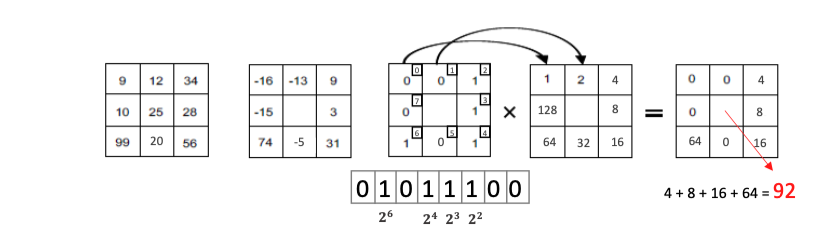


In [ ]:
# LOCAL BINARY PATTERNS (LBP)
from skimage.feature import local_binary_pattern
img = cv2.imread('images/photographer.png')

# Definimos los parámetros iniciales
R = 1 # Radio
P = 8*R # Número de píxeles vecinos
epsilon = 1e-7 # Para normalizar el histograma

# Extraemos la imagen LBP
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp_image = local_binary_pattern(img_gray, P, R, method='uniform') #Método uniforme, el más utilizado
a,b = np.unique(lbp_image, return_counts=True)

# Calculamos el histograma
lbp_image = np.uint8(lbp_image)
hist = cv2.calcHist([lbp_image.ravel()], [0], None, [P+2], [0, P+2])

# Normalizamos el histograma
hist = hist.astype("float")
hist /= (hist.sum() + epsilon)

# Los P+2=10 bins del histograma serán los 10 atributos que nos permitirán caracterizar una imagen

# Visualizamos la imagen LBP
figs, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbp_image, cmap='gray')
plt.show()

# Visualizamos el histograma
plt.plot(hist)
plt.grid(True)
plt.show()

"""
El descriptor me genera un histograma de 10 bins (características). 
Aca debemos analizar las características que nos pueden ser de utilidad para poder evaluar un problema
"""